<a href="https://colab.research.google.com/github/Fezacode92/Fezacode92/blob/main/toxicity_LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow tensforflow-gpu pandas matplotlib sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensforflow-gpu (from versions: none)
ERROR: No matching distribution found for tensforflow-gpu


In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

# New Section

In [17]:
df = pd.read_csv('/content/train.csv',error_bad_lines=False,engine="python")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 4839: unexpected end of data


In [18]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [20]:
df.iloc[0]['comment_text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [22]:
df[df.columns[2:]].iloc[7]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 7, dtype: int64

In [23]:
from tensorflow.keras.layers import TextVectorization

In [24]:
X = df['comment_text']
y = df[df.columns[2:]].values
 

In [25]:
df[df.columns[2:]].values

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [26]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [27]:
MAX_FEATURES = 200000 # number of words in the vocab

In [29]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [30]:
vectorizer.adapt(X.values)

In [31]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'i',
 'a',
 'and',
 'you',
 'is',
 'that',
 'in',
 'it',
 'for',
 'this',
 'not',
 'on',
 'be',
 'as',
 'have',
 'are',
 'with',
 'your',
 'if',
 'was',
 'article',
 'or',
 'but',
 'page',
 'my',
 'an',
 'by',
 'from',
 'at',
 'do',
 'me',
 'about',
 'so',
 'what',
 'wikipedia',
 'can',
 'there',
 'all',
 'has',
 'would',
 'its',
 'like',
 'will',
 'no',
 'one',
 'just',
 'talk',
 'they',
 'he',
 'please',
 'any',
 'which',
 'been',
 'dont',
 'we',
 'ass',
 'here',
 'should',
 'other',
 'more',
 'see',
 'his',
 'some',
 'im',
 'who',
 'also',
 'think',
 'know',
 'how',
 'because',
 'why',
 'out',
 'am',
 'then',
 'edit',
 'were',
 'people',
 'only',
 'up',
 'use',
 'articles',
 'may',
 'now',
 'time',
 'did',
 'their',
 'being',
 'when',
 'than',
 'thanks',
 'get',
 'even',
 'information',
 'make',
 'good',
 'them',
 'sources',
 'well',
 'could',
 'had',
 'want',
 'fuck',
 'way',
 'very',
 'does',
 'deletion',
 'first',
 'really',
 'section',
 'suc

In [32]:
vectorized_text = vectorizer(X.values)

In [33]:
len(X)

4837

In [34]:
vectorized_text

<tf.Tensor: shape=(4837, 1800), dtype=int64, numpy=
array([[  621,    75,     2, ...,     0,     0,     0],
       [23051,    53,  1856, ...,     0,     0,     0],
       [  497,   409,    68, ...,     0,     0,     0],
       ...,
       [  456, 12820,   449, ...,     0,     0,     0],
       [    5,   121,     6, ...,     0,     0,     0],
       [ 2495,    92,     5, ...,     0,     0,     0]])>

In [36]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [38]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [49]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [50]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [52]:
history = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
212/212 [==============================] - 28s 96ms/step - loss: 0.1742 - val_loss: 0.0845
Epoch 2/20
212/212 [==============================] - 20s 92ms/step - loss: 0.0818 - val_loss: 0.0707
Epoch 3/20
212/212 [==============================] - 19s 92ms/step - loss: 0.0588 - val_loss: 0.0393
Epoch 4/20
212/212 [==============================] - 20s 96ms/step - loss: 0.0430 - val_loss: 0.0422
Epoch 5/20
212/212 [==============================] - 20s 95ms/step - loss: 0.0389 - val_loss: 0.0433
Epoch 6/20
212/212 [==============================] - 20s 94ms/step - loss: 0.0372 - val_loss: 0.0344
Epoch 7/20
212/212 [==============================] - 20s 93ms/step - loss: 0.0347 - val_loss: 0.0284
Epoch 8/20
212/212 [==============================] - 20s 93ms/step - loss: 0.0294 - val_loss: 0.0432
Epoch 9/20
212/212 [==============================] - 20s 93ms/step - loss: 0.0297 - val_loss: 0.0290
Epoch 10/20
212/212 [==============================] - 20s 93ms/step - loss: 0.030

In [53]:
from matplotlib import pyplot as plt

In [54]:
history.history

{'loss': [0.17421819269657135,
  0.08181840181350708,
  0.05879591405391693,
  0.04300205782055855,
  0.03889070078730583,
  0.03724455460906029,
  0.03466711565852165,
  0.029354741796851158,
  0.02970638871192932,
  0.030026327818632126,
  0.027058947831392288,
  0.02728121727705002,
  0.026655342429876328,
  0.022389771416783333,
  0.023333322256803513,
  0.023428216576576233,
  0.020347068086266518,
  0.018425103276968002,
  0.01664920710027218,
  0.017459865659475327],
 'val_loss': [0.08448732644319534,
  0.0706629827618599,
  0.039324067533016205,
  0.04223848506808281,
  0.043341945856809616,
  0.03441725671291351,
  0.028436949476599693,
  0.04315938428044319,
  0.029014190658926964,
  0.026828961446881294,
  0.0314953550696373,
  0.023333709686994553,
  0.026187598705291748,
  0.019962958991527557,
  0.019488485530018806,
  0.019269222393631935,
  0.01655171439051628,
  0.017290273681282997,
  0.013002825900912285,
  0.010692066513001919]}

<Figure size 576x360 with 0 Axes>

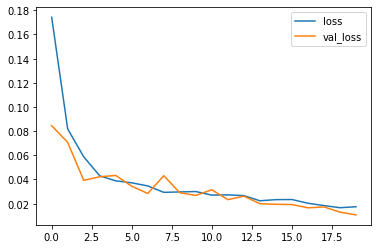

In [57]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [58]:
input_text = vectorizer('You freaking suck!')

In [59]:
batch = test.as_numpy_iterator().next()

In [60]:
model.predict(np.array([input_text]))

1/1 [==============================] - 1s 856ms/step


array([[9.9981707e-01, 2.4631289e-03, 9.8281163e-01, 8.1702851e-04,
        5.6166708e-01, 9.9247126e-03]], dtype=float32)

In [61]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 85ms/step


In [62]:
test.as_numpy_iterator().next()

(array([[    9,    14,    67, ...,     0,     0,     0],
        [    5,   243,   516, ...,     0,     0,     0],
        [  141,     8,    13, ...,     0,     0,     0],
        ...,
        [    8,    19,    48, ...,     0,     0,     0],
        [  462, 14220,  2277, ...,     0,     0,     0],
        [    8,    47,    17, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [63]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [64]:
model.predict(batch_X)

1/1 [==============================] - 0s 67ms/step


array([[7.72817643e-10, 2.42102027e-16, 1.26612737e-13, 2.71759681e-08,
        9.22633414e-10, 2.05382781e-12],
       [2.35121930e-04, 1.19600940e-09, 9.84810171e-08, 1.20702694e-04,
        1.85874669e-05, 2.90845264e-07],
       [7.10041817e-11, 2.30852279e-17, 1.47914568e-14, 7.02504188e-09,
        1.85104085e-10, 3.30117281e-13],
       [1.51178358e-11, 4.14867515e-18, 3.23862243e-15, 2.64297184e-09,
        6.15488216e-11, 8.72680631e-14],
       [9.07365393e-06, 3.14861089e-11, 3.59301211e-09, 1.58453895e-05,
        1.59299418e-06, 1.71281318e-08],
       [1.04373177e-08, 1.03696416e-14, 3.03256552e-12, 2.04527524e-07,
        9.03555541e-09, 3.56006682e-11],
       [1.50890647e-10, 1.13714464e-16, 5.34134979e-14, 1.45814703e-08,
        4.78707018e-10, 1.06404946e-12],
       [9.99219537e-01, 4.51943158e-08, 1.60832642e-04, 7.02810823e-04,
        1.22375339e-02, 5.49967581e-06],
       [2.78287121e-06, 1.90468973e-12, 3.90126959e-10, 5.07568575e-06,
        3.02698680e-07, 

In [65]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 88ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0]])

In [66]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0]])

In [67]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [68]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [69]:
for batch in test.as_numpy_iterator():
  # Unpack the batch
  X_true, y_true = batch
  yhat = model.predict(X_true)

  # flatten the predictions
  y_true = y_true.flatten()
  yhat = yhat.flatten()

  
  pre.update_state(y_true, yhat)
  re.update_state(y_true, yhat)
  acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 61ms/step


In [71]:
print(f'precision: {pre.result().numpy()},Recall:{re.result().numpy()},Accuracy:{acc.result().numpy()}')

precision: 0.9469026327133179,Recall:0.9385964870452881,Accuracy:0.4000000059604645


In [72]:
!pip install gradio jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.8 MB 15.6 MB/s 
     |████████████████████████████████| 106 kB 72.6 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
     |████████████████████████████████| 278 kB 72.5 MB/s 
     |████████████████████████████████| 2.3 MB 60.8 MB/s 
     |████████████████████████████████| 56 kB 5.9 MB/s 
     |████████████████████████████████| 55 kB 4.1 MB/s 
     |████████████████████████████████| 64 kB 3.9 MB/s 
     |████████████████████████████████| 80 kB 8.8 MB/s 
     |████████████████████████████████| 69 kB 7.7 MB/s 
     |████████████████████████████████| 58 kB 7.8 MB/s 
     |████████████████████████████████| 50 kB 8.3 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4711 sha256=699655dd7b60e671fa6d1b03950a4d561ca6f441167fec11f85224449467868d
  Stored in direc

In [73]:
import gradio as gr

In [74]:
model.save('toxicity.h5')

In [75]:
model = tf.keras.models.load_model('toxicity.h5')

In [76]:
input_str = vectorizer('hey i freaking hate you!')

In [77]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 962ms/step


In [78]:
res

array([[9.9516559e-01, 4.4957010e-04, 2.0862286e-01, 7.9015624e-03,
        3.9863974e-01, 5.5019693e-03]], dtype=float32)

In [80]:
def score_comment(comment):
  vectorized_comment = vectorizer([comment])
  results = model.predict(vectorized_comment)

  text = ''
  for idx, col in enumerate(df.columns[2:]):
    text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

In [81]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.inputs.Textbox(lines=2, placeholder='comment to score'),
                         outputs='text')

/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:26: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [82]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2b8a98e7-0a43-418e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
